In [0]:
import torch
import torch.nn
import torch.optim
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable
from random import randint

In [0]:
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [0]:
BATCH_SIZE = 128
EPOCHS_AUTOENCODER = 10
EPOCHS_PRETRAINING = 20
EPOCHS_FINETUNING = 20
EPOCHS_VAE = 50

# Exercise 1: Convolutional Autoencoder

Steps:
1. Load MNIST train and test sets. Split the original training data into 95% training and 5% validation data.
2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules).
3. Train the convolutional autoencoder, with different bottleneck sizes. Plot the train and validation loss curves of all autoencoders in the same figure.
4. Compute the avg. image reconstruction error (MSE) of the trained models on the MNIST validation and test sets. Show the results in a table, including #params of each model.
5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. Show them along with their reconstructions.
Generate 5 new images by injecting random values as input to the decoder. Show them.


## Module definition

Our autoencoder will be defined by the `ConvolutionalAutoencoder` class which uses a `ConvolutionalEncoder` object to encode followed a `ConvolutionalDecoder` object to decode. The `ConvolutionalEncoder` and `ConvolutionalDecoder` classes make use of `n_blocks` `ConvolutionalBlock`s or `DeconvolutionalBlock`s which are composed of `layer_per_block` convolution layers with the same number of filters.

The dimensionality is reduced by applying 2-factor spatial downsampling at each block. The number of filters is doubled for each subsequent block. The decoder makes the exact oposite process.

The final layer uses a tanh activation.

Very similar to the `ConvolutionalAutoencoder`, there is the `ConvolutionalAutoencoderReducedLatentDim` class which includes 2 fully-connected layers between the encoder and decoder. The first one projects from the encoder's feature maps to a vector of `latent_dimensionality` dimensions, the second one does the opposite.

In [0]:
# %load models.py
import torch
import torch.nn


class ConvolutionalAutoencoder(torch.nn.Module):

    def __init__(self, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method

        self.encoder = ConvolutionalEncoder(n_blocks, downsampling_method,
                                            layers_per_block=layers_per_block)
        self.decoder = ConvolutionalDecoder(n_blocks, upsampling_method,
                                            self.encoder.output_channels,
                                            layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.decoder(code)
        return reconstruction


class ConvolutionalAutoencoderReducedLatentDim(torch.nn.Module):

    def __init__(self, input_shape, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2, latent_dimensionality=50):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method
        self.latent_dimensionality = latent_dimensionality

        # Encoder: Convolutional blocks + Linear
        self.convolutional_encoder = ConvolutionalEncoder(
            n_blocks, downsampling_method, layers_per_block=layers_per_block)
        self.encoder_output_shape = (self.convolutional_encoder.init_filters * 2 ** (n_blocks - 1),
                                     input_shape[0] // 2 ** n_blocks,
                                     input_shape[1] // 2 ** n_blocks)
        self.encoder = torch.nn.Sequential(
            self.convolutional_encoder,
            torch.nn.Flatten(),
            torch.nn.Linear(self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2],
                            latent_dimensionality),
            torch.nn.ReLU()
        )

        # Decoder: Linear + Convolutional blocks
        self.linear_decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dimensionality,
                            self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2]),
            torch.nn.ReLU()
        )
        self.convolutional_decoder = ConvolutionalDecoder(
            n_blocks, upsampling_method,
            self.convolutional_encoder.output_channels, layers_per_block)

    def forward(self, x):
        code = self.encoder(x)
        reconstruction = self.convolutional_decoder(
            self.linear_decoder(code).view((-1,) + self.encoder_output_shape))
        return reconstruction


class ConvolutionalEncoder(torch.nn.Module):
    DOWNSAMPLING_METHODS = ["max-pooling", "avg-pooling", "stride-2"]

    def __init__(self, n_blocks, downsampling_method, init_filters=16,
                 layers_per_block=2, kernel_size=5, input_channels=1):
        super().__init__()
        self.n_blocks = n_blocks
        assert downsampling_method in self.DOWNSAMPLING_METHODS
        self.downsampling_method = downsampling_method
        self.layers_per_block = layers_per_block
        self.init_filters = init_filters
        self.kernel_size = kernel_size
        self.input_channels = input_channels

        layers = []

        # First layer so we have <input_channels> channels.
        n_filters = init_filters
        layers.append(
            ConvolutionalBlock(input_channels, n_filters, kernel_size, 1))

        # Encoding blocks.
        input_channels = n_filters
        for _ in range(n_blocks):
            if downsampling_method == "max-pooling":
                # Convolutional block + max pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.MaxPool2d(2)
                )
            elif downsampling_method == "avg-pooling":
                # Convolutional block + average pooling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.AvgPool2d(2)
                )
            else:
                # Stride-2 convolution.
                conv_block = ConvolutionalBlock(input_channels, n_filters,
                                                kernel_size,
                                                layers_per_block,
                                                last_stride=2)
            layers.append(conv_block)
            # Double the number of filters.
            input_channels = n_filters
            n_filters = 2 * n_filters

        self.encoder = torch.nn.Sequential(*layers)
        self.output_channels = input_channels

    def forward(self, x):
        return self.encoder(x)


class ConvolutionalDecoder(torch.nn.Module):
    UPSAMPLING_METHODS = ["transposed", "bilinear", "bicubic", "nearest"]

    def __init__(self, n_blocks, upsampling_method, input_channels,
                 layers_per_block=2, kernel_size=5, output_channels=1,
                 activation="tanh"):
        super().__init__()
        self.n_blocks = n_blocks
        assert upsampling_method in self.UPSAMPLING_METHODS
        self.upsampling_method = upsampling_method
        self.layers_per_block = layers_per_block
        self.input_channels = input_channels
        self.kernel_size = kernel_size
        self.output_channels = output_channels
        self.activation = activation

        layers = []

        # Decoding blocks.
        n_filters = input_channels
        for _ in range(n_blocks):
            if upsampling_method == "transposed":
                # Deconvolutional block
                conv_block = DeconvolutionalBlock(input_channels, n_filters,
                                                  kernel_size, layers_per_block,
                                                  stride=2)
            else:
                # Upsampling.
                conv_block = torch.nn.Sequential(
                    ConvolutionalBlock(input_channels, n_filters, kernel_size,
                                       layers_per_block),
                    torch.nn.Upsample(scale_factor=2, mode=upsampling_method)
                )
            layers.append(conv_block)
            # Half the number of filters.
            input_channels = n_filters
            n_filters = n_filters // 2

        # Last layer so we have <output_channels> channel.
        layers.append(torch.nn.Conv2d(input_channels, output_channels, kernel_size,
                                      padding=kernel_size // 2))
        if activation == "tanh":
            layers.append(torch.nn.Tanh())
        elif activation == "sigmoid":
            layers.append(torch.nn.Sigmoid())

        self.decoder = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class ConvolutionalBlock(torch.nn.Module):
    """

    Applies n_layers convolutional layers with the same number of
    filters and filter sizes with ReLU activations
    keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers,
                 last_stride=1):
        super().__init__()
        layers = []
        padding = kernel_size // 2  # To keep the same size.

        for i in range(n_layers):
            if i == 0:  # First layer with correct input channels.
                layers.append(torch.nn.Conv2d(input_channels, n_filters,
                                              kernel_size, padding=padding))
            elif 0 < i < n_layers:  # Intermediate layers.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, padding=padding))
            else:  # Last layer with stride.
                layers.append(torch.nn.Conv2d(n_filters, n_filters,
                                              kernel_size, last_stride, padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class DeconvolutionalBlock(torch.nn.Module):
    """

    Applies a transposed convolution followed by n_layers-1 convolutional
    layers with the same number of filters and filter sizes with ReLU
    activations keeping the same spacial size.
    """

    def __init__(self, input_channels, n_filters, kernel_size, n_layers, stride):
        super().__init__()
        layers = []
        padding = kernel_size // 2

        # Transposed convolution layer.
        layers.append(torch.nn.ConvTranspose2d(input_channels, n_filters,
                                               kernel_size, stride, padding, 1))
        layers.append(torch.nn.ReLU())

        for _ in range(n_layers - 1):
            layers.append(torch.nn.Conv2d(n_filters, n_filters, kernel_size,
                                          padding=padding))
            layers.append(torch.nn.ReLU())

        # To sequentially apply the layers.
        self.block = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

To do a quick test, we will pass a random image and check if the output is of the same size as the input.

In [0]:
image = torch.randn((10, 1, 128, 128))
autoencoder = ConvolutionalAutoencoderReducedLatentDim(input_shape=(128, 128),
                                                       n_blocks=2,
                                                       downsampling_method='max-pooling',
                                                       upsampling_method='nearest',
                                                       layers_per_block=2,
                                                       latent_dimensionality=50)
output = autoencoder(image)
assert output.shape == (10, 1, 128, 128)

## Dataset

We split the training set and normalize the input images with mean and variance of the training set found on the internet.

In [0]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Mean and std from internet...
])

In [7]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=transform, download=True)

0it [00:00, ?it/s]

9920512it [00:07, 1294225.32it/s]                             


Extracting mnist_dataset/MNIST/raw/train-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 58357.49it/s]                           
0it [00:00, ?it/s]

Extracting mnist_dataset/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw


1654784it [00:01, 947988.46it/s]                             
0it [00:00, ?it/s]

Extracting mnist_dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_dataset/MNIST/raw


8192it [00:00, 22122.61it/s]            

Extracting mnist_dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_dataset/MNIST/raw
Processing...
Done!


In [0]:
dataset_len = len(mnist)

In [9]:
dataset_len * 0.95

57000.0

In [0]:
mnist_train, mnist_val = torch.utils.data.random_split(mnist, [57000, dataset_len - 57000])

In [0]:
train_dataloader = torch.utils.data.DataLoader(mnist_train,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)

In [0]:
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=BATCH_SIZE)

To create our autoencoder we need to know the size of our images.

In [13]:
image, label = mnist_train[0]
image.shape

torch.Size([1, 28, 28])

## Training

We will first train an autoencoder with a bottleneck of size 50, **2 blocks of 2 convolutional layers** on each block (each in the encoder and decoder), using **max-pooling** for downsampling and **nearest-neighbour** for upsampling.

In [0]:
autoencoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=50
).to(device)

We use the mean square error as our loss function and Adam as our optimization algorithm with a learning rate of 0.001.  
We use 'sum' as reduction to compute the image reconstruction error instead of the pixel reconstruction error.

In [0]:
mse = torch.nn.MSELoss(reduction='sum')
adam = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

Define our `train` function that will be called at each epoch.

In [0]:
def train(model, dataloader, criterion, optimizer, epoch, loss_history, log_interval=100):
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        # Divide by batch size to compute mean image reconstruction error.
        loss = criterion(reconstructed, images) / images.shape[0]
        loss.backward()   # Backprop.
        optimizer.step()  # Parameter updates.

        loss_history.append(loss.item())
        if i % log_interval == 0:
            print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

Very similar to the `train` function, we define our `test` function to validate. In this case we don't backpropagate and update our parameters.

In [0]:
def test(model, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    for batch in dataloader:
        images = batch[0].to(device)
        reconstructed = model(images)
        loss += criterion(reconstructed, images).item()
        total += images.shape[0]

    mean_loss = loss / total
    loss_history.append(mean_loss)  
    print('[%d, test] loss: %.3f' % (epoch + 1, mean_loss))
    return mean_loss

This is our training loop. Firstly, we call the `test` function so our validation loss curve includes the initial/untrained "behaviour".

In [18]:
training_loss = []    #
validation_loss = []  # Here we save the training process.

for epoch in range(EPOCHS_AUTOENCODER):
    autoencoder.eval()
    with torch.no_grad():
        _ = test(autoencoder, val_dataloader, mse, epoch, validation_loss)
    autoencoder.train()
    train(autoencoder, train_dataloader, mse, adam, epoch, training_loss)
    # if early_stopping(validation_loss):
    #     break

autoencoder.eval()
with torch.no_grad():
    test(autoencoder, val_dataloader, mse, epoch, validation_loss)

[1, test] loss: 796.878
[1, 0] loss: 758.104
[1, 100] loss: 549.868
[1, 200] loss: 475.533
[1, 300] loss: 388.958
[1, 400] loss: 348.533
[2, test] loss: 337.644
[2, 0] loss: 315.081
[2, 100] loss: 321.690
[2, 200] loss: 300.754
[2, 300] loss: 308.555
[2, 400] loss: 287.367
[3, test] loss: 304.376
[3, 0] loss: 303.161
[3, 100] loss: 284.149
[3, 200] loss: 298.843
[3, 300] loss: 293.873
[3, 400] loss: 288.292
[4, test] loss: 298.220
[4, 0] loss: 270.957
[4, 100] loss: 286.857
[4, 200] loss: 286.826
[4, 300] loss: 293.875
[4, 400] loss: 294.413
[5, test] loss: 292.914
[5, 0] loss: 285.556
[5, 100] loss: 276.173
[5, 200] loss: 290.535
[5, 300] loss: 285.745
[5, 400] loss: 292.952
[6, test] loss: 290.858
[6, 0] loss: 294.831
[6, 100] loss: 288.973
[6, 200] loss: 281.159
[6, 300] loss: 277.549
[6, 400] loss: 292.455
[7, test] loss: 288.230
[7, 0] loss: 280.003
[7, 100] loss: 274.603
[7, 200] loss: 285.313
[7, 300] loss: 286.547
[7, 400] loss: 288.153
[8, test] loss: 285.764
[8, 0] loss: 282.

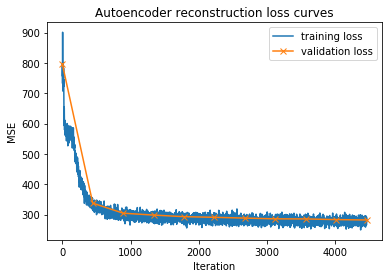

In [19]:
plt.title('Autoencoder reconstruction loss curves')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend();

We can see that the loss quickly reduces and then it doesn't improve much. The validation curve is similar to the training one, so we can say it doesn't overfit the training data.

In log-scale:

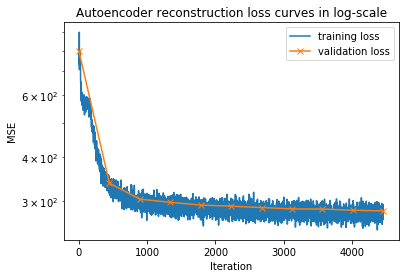

In [20]:
plt.title('Autoencoder reconstruction loss curves in log-scale')
plt.yscale('log')
plt.plot(training_loss, label='training loss')
plt.plot(np.linspace(0, len(training_loss), len(validation_loss)), validation_loss, '-x', label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend();

Now we'll try to reconstruct a image from the test dataset.

In [0]:
mnist_test = torchvision.datasets.MNIST('mnist_dataset', train=False, transform=transform)
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [0]:
def show_image(image, autoencoder, title=None):
    reconstructed = autoencoder(image.to(device).unsqueeze(0))
    if title:
        plt.suptitle(title)
    plt.subplot(121).set_title('Original image')
    plt.imshow(image.reshape((28, 28)), cmap='gray')
    plt.subplot(122).set_title('Reconstructed image')
    plt.imshow(reconstructed.reshape((28, 28)).detach().cpu().numpy(), cmap='gray');

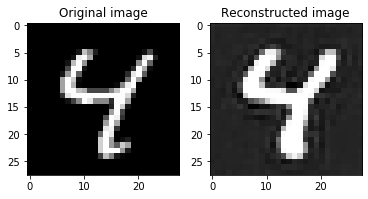

In [23]:
show_image(mnist_test[6][0], autoencoder)

We can see some information is loss, but the reconstruction is pretty accurate.

## Varying bottleneck size


In [0]:
mse = torch.nn.MSELoss(reduction='sum')

In [25]:
bottleneck_sizes = [2, 5, 10, 50]
autoencoders = {}
min_loss = float("inf")
for bottleneck_size in bottleneck_sizes:
    training_loss = []    # Here we save the training process.
    validation_loss = []  # And here the validation loss after each epoch

    print("*"*15 + f"Autoencoder bottleneck size {bottleneck_size}" + "*"*15)
  
    autoencoder = ConvolutionalAutoencoderReducedLatentDim(
        input_shape=(28, 28),
        n_blocks=2,
        downsampling_method='max-pooling',
        upsampling_method='nearest',
        layers_per_block=2,
        latent_dimensionality=bottleneck_size
    ).to(device)
    adam = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

    for epoch in range(EPOCHS_AUTOENCODER):
        autoencoder.eval()
        with torch.no_grad():
            loss = test(autoencoder, val_dataloader, mse, epoch, validation_loss)
        if loss < min_loss:
            torch.save({'encoder': autoencoder.encoder.state_dict(),
                        'bottleneck_size': bottleneck_size}, 'encoder.pt')
        autoencoder.train()
        train(autoencoder, train_dataloader, mse, adam, epoch, training_loss, 500)
        
        # if early_stopping(validation_loss):
        #     break

    autoencoder.eval()
    with torch.no_grad():
        test(autoencoder, val_dataloader, mse, epoch, validation_loss)
    autoencoders[f"bottleneck_{bottleneck_size}"] = {"val_loss": validation_loss, "model": autoencoder}

***************Autoencoder bottleneck size 2***************
[1, test] loss: 792.791
[1, 0] loss: 805.487
[2, test] loss: 565.696
[2, 0] loss: 560.298
[3, test] loss: 565.254
[3, 0] loss: 552.801
[4, test] loss: 564.984
[4, 0] loss: 566.081
[5, test] loss: 564.930
[5, 0] loss: 565.858
[6, test] loss: 564.639
[6, 0] loss: 568.591
[7, test] loss: 564.684
[7, 0] loss: 569.074
[8, test] loss: 564.763
[8, 0] loss: 554.020
[9, test] loss: 565.532
[9, 0] loss: 542.851
[10, test] loss: 564.761
[10, 0] loss: 552.214
[10, test] loss: 564.558
***************Autoencoder bottleneck size 5***************
[1, test] loss: 792.000
[1, 0] loss: 808.815
[2, test] loss: 565.538
[2, 0] loss: 541.175
[3, test] loss: 565.243
[3, 0] loss: 576.991
[4, test] loss: 565.073
[4, 0] loss: 531.558
[5, test] loss: 565.002
[5, 0] loss: 558.884
[6, test] loss: 564.797
[6, 0] loss: 561.960
[7, test] loss: 564.796
[7, 0] loss: 566.300
[8, test] loss: 564.816
[8, 0] loss: 580.443
[9, test] loss: 564.731
[9, 0] loss: 543.35

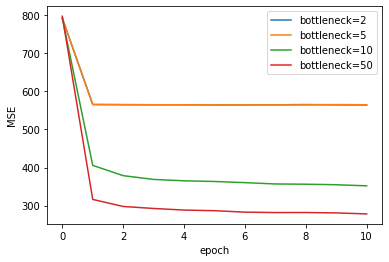

In [26]:
plt.figure()
for bottleneck_size in autoencoders:
    plt.plot(autoencoders[bottleneck_size]["val_loss"], label=bottleneck_size.replace("_", "="))
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend();

We can see a fast convergence speed in all cases, but (as we could predict) the larger the bottleneck size the lower loss.

### Average image reconstruction loss

This section presents the average image reconstruction loss for the different autoencoders from previous section.

In [0]:
def get_num_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

def get_avg_image_reconstruction_loss(model, dataloader, criterion):
    loss = 0
    total = 0
    for batch in dataloader:
        images = batch[0].to(device)
        reconstructed = model(images)
        loss += criterion(reconstructed, images).item()
        total += images.shape[0]

    mean_loss = loss / total
    return mean_loss

In [28]:
tbl = PrettyTable()
tbl.field_names = ["Model", "Number of parameters", "Validation loss", "Test loss"]
for model_name, model_info in autoencoders.items():
    autoencoder = model_info["model"]
    num_params = get_num_parameters(autoencoder)
    val_loss = get_avg_image_reconstruction_loss(autoencoder, val_dataloader, mse)
    test_loss = get_avg_image_reconstruction_loss(autoencoder, test_dataloader, mse)
    tbl.add_row([model_name, num_params, val_loss, test_loss])

print(tbl)

+---------------+----------------------+--------------------+--------------------+
|     Model     | Number of parameters |  Validation loss   |     Test loss      |
+---------------+----------------------+--------------------+--------------------+
|  bottleneck_2 |        130451        | 564.5578385416667  | 559.4573369140625  |
|  bottleneck_5 |        139862        |   565.0036484375   | 559.9860087890625  |
| bottleneck_10 |        155547        |  351.865623046875  | 351.00136474609377 |
| bottleneck_50 |        281027        | 278.04903255208336 | 278.3268048828125  |
+---------------+----------------------+--------------------+--------------------+


Again, the larger the bottleneck size the lower the error. But we can see the number of parameters quickly raises.

### Generating random images taking 5 elements from the test set.

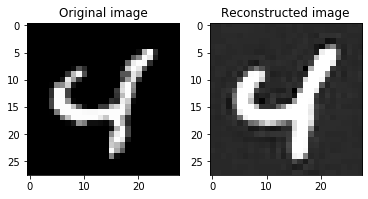

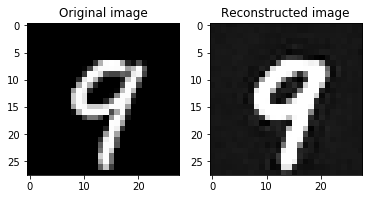

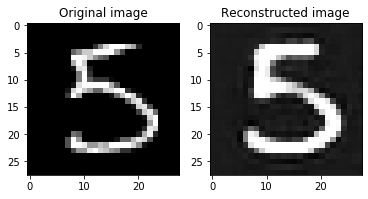

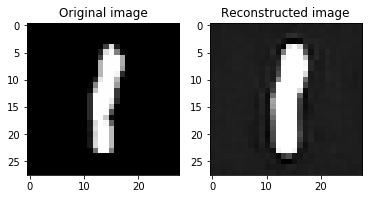

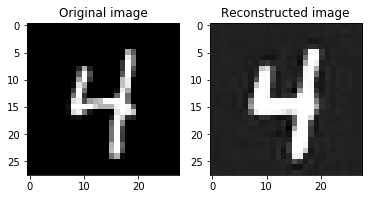

In [29]:
autoencoder = autoencoders["bottleneck_50"]["model"]
random_indexes = [randint(0,len(test_dataloader)) for _ in range(5)]
for index in random_indexes:
    plt.figure()
    show_image(mnist_test[index][0], autoencoder)

The reconstructed images look very similar to the original ones.

### Presenting 5 random generated images to the autoencoder.

In [0]:
def generate_image(model):
    noise = torch.randn((1, 50)).to(device)
    generated = model.convolutional_decoder(model.linear_decoder(noise).view((1,) + model.encoder_output_shape))
    plt.imshow(generated.squeeze().detach().cpu().numpy(), cmap='gray')


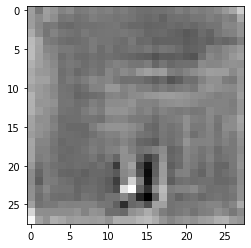

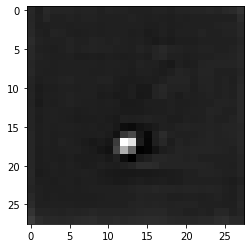

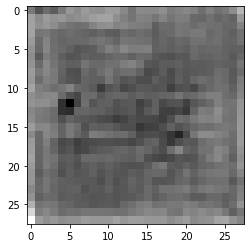

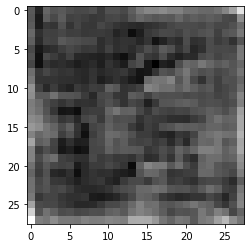

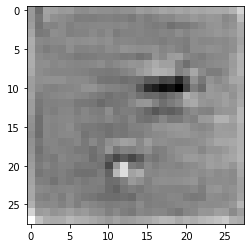

In [32]:
for _ in range(5):
    plt.figure()
    generate_image(autoencoder)

The generated images don't look like the training data at all.

# Exercise 2: Transfer Learning

## Steps:

1. Select a subset of 100 images and their associated labels from the MNIST training data.
2. Select one of the previously trained autoencoders.
3. Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.
3. Pretraining: use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.
4. Fine-tuning: do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.
5. From scratch: train the model on the 100 samples without reusing the decoder weights at all.
6. Show the accuracy of the four models on the MNIST test set in a table.


## Pretraining

We don't need to define a softmax layer, as the `CrossEntropyLoss` class internally applies it.

In [0]:
# Load saved autoencoder training checkpoint.
autoencoder_checkpoint = torch.load('encoder.pt')
bottleneck_size = autoencoder_checkpoint['bottleneck_size']
encoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).encoder.to(device)
encoder.load_state_dict(autoencoder_checkpoint['encoder'])

# Define classification layer.
classifier = torch.nn.Linear(bottleneck_size, 10).to(device)

We use the cross-entropy as our loss function and Adam as our optimization algorithm with a learning rate of 0.01.

In [0]:
cross_entropy = torch.nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(classifier.parameters(), lr=0.01)

We create a subset dataset using the pytorch's `Subset` class with the first 100 samples from the training split.

In [0]:
training_subset = torch.utils.data.Subset(mnist_train, range(100))
subset_dataloader = torch.utils.data.DataLoader(training_subset,
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                num_workers=4)

Define our `classification_train` function that will be called at each epoch. The function takes the classifier network as well as the encoder network. It first projects the input image to the latent space and then applies the classification layer.

The output of the encoder is detached so the gradients are not computed (because we dont need them).

In [0]:
def classification_train(classifier, encoder, dataloader, criterion, optimizer, epoch, loss_history):
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        optimizer.zero_grad()
        # To latent space.
        codes = encoder(images).detach()
        # Classify from latent space.
        outputs = classifier(codes)
        loss = criterion(outputs, labels)
        loss.backward()   # Backprop.
        optimizer.step()  # Parameter updates.

        loss_history.append(loss.item())
        print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

Very similar to the `classification_train` function, we define our `classification_test` function to validate. In this case we don't backpropagate and update our parameters. We also compute the accuracy by summing all the correct predictions and dividing by the total number of images.

In [0]:
def classification_test(classifier, encoder, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        codes = encoder(images)
        outputs = classifier(codes)
        loss += criterion(outputs, labels).item()
        # Compute average accuracy.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    mean_loss = loss / (i + 1)
    acc = 100 * correct / total
    loss_history.append(mean_loss)  
    print('[%d, test] loss: %.3f accuracy: %.3f' % (epoch + 1, mean_loss, acc))
    return mean_loss, acc

We pass the `encoder` submodule of the `autoencoder` object as the `encoder` parameter of the above-defined functions.

In [38]:
pretraining_training_loss = []
pretraining_validation_loss = []  # Here we save the training process.
min_loss = float('inf')

for epoch in range(EPOCHS_PRETRAINING):
    classifier.eval()
    with torch.no_grad():
        loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, pretraining_validation_loss)
        if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_pretrain.pt')
    classifier.train()
    classification_train(classifier, encoder, subset_dataloader, cross_entropy, optimizer_adam, epoch, pretraining_training_loss)

classifier.eval()
with torch.no_grad():
    loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, pretraining_validation_loss)
    if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_pretrain.pt')

[1, test] loss: 5.721 accuracy: 10.600
[1, 0] loss: 5.565
[2, test] loss: 3.851 accuracy: 11.000
[2, 0] loss: 3.794
[3, test] loss: 3.189 accuracy: 21.200
[3, 0] loss: 3.114
[4, test] loss: 3.095 accuracy: 23.700
[4, 0] loss: 3.018
[5, test] loss: 3.086 accuracy: 25.767
[5, 0] loss: 2.970
[6, test] loss: 3.078 accuracy: 26.567
[6, 0] loss: 2.960
[7, test] loss: 2.855 accuracy: 26.300
[7, 0] loss: 2.746
[8, test] loss: 2.544 accuracy: 29.067
[8, 0] loss: 2.454
[9, test] loss: 2.283 accuracy: 35.733
[9, 0] loss: 2.182
[10, test] loss: 2.130 accuracy: 41.567
[10, 0] loss: 2.003
[11, test] loss: 2.021 accuracy: 44.867
[11, 0] loss: 1.876
[12, test] loss: 1.885 accuracy: 47.300
[12, 0] loss: 1.715
[13, test] loss: 1.734 accuracy: 50.633
[13, 0] loss: 1.523
[14, test] loss: 1.640 accuracy: 52.800
[14, 0] loss: 1.366
[15, test] loss: 1.633 accuracy: 51.533
[15, 0] loss: 1.297
[16, test] loss: 1.654 accuracy: 49.300
[16, 0] loss: 1.271
[17, test] loss: 1.640 accuracy: 49.133
[17, 0] loss: 1.23

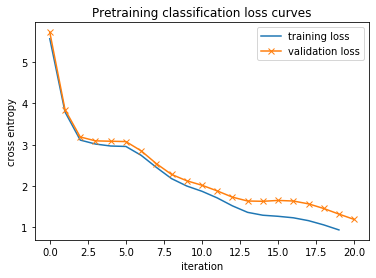

In [39]:
plt.title('Pretraining classification loss curves')
plt.plot(pretraining_training_loss, label='training loss')
plt.plot(np.linspace(0, len(pretraining_training_loss), len(pretraining_validation_loss)), pretraining_validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();

In [0]:
test_dataloader = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE)

In [41]:
classification_test(classifier, encoder, test_dataloader, cross_entropy, epoch, []);

[20, test] loss: 1.126 accuracy: 63.740


We can see a steady decrease in the training and validation losses.

## Pretrain + Fine-tuning

In this section we will continue training the model, but we will update the encoder too with a small learning rate. 

We modify the optimizer in order to have different learning rates for the encoder and the classifier.

The `classification_test` function doesn't need to be modified.

We define a new Adam optimizer for the encoder network with a small learning rate of 0.0001. The classification network optimizer is reused.

In [0]:
optimizer_adam = torch.optim.Adam([
    {"params": classifier.parameters()},
    {"params": encoder.parameters(), "lr":0.0001}
])

Note that we don't redefine the `training_loss` and `validation_loss` list, so they will have the values of the pretraining stage too.

In [43]:
min_loss = float('inf')

for epoch in range(EPOCHS_FINETUNING):
    classifier.eval()
    encoder.eval()
    with torch.no_grad():
        loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, pretraining_validation_loss)
        if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_pretraining+fine-tuning.pt')
    classifier.train()
    encoder.train()
    classification_train(classifier, encoder, subset_dataloader,
                         cross_entropy, optimizer_adam, epoch, pretraining_training_loss)

classifier.eval()
encoder.eval()
with torch.no_grad():
    loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, pretraining_validation_loss)
    if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_pretraining+fine-tuning.pt')

[1, test] loss: 1.195 accuracy: 61.933
[1, 0] loss: 0.830
[2, test] loss: 1.152 accuracy: 63.667
[2, 0] loss: 0.802
[3, test] loss: 1.123 accuracy: 65.033
[3, 0] loss: 0.787
[4, test] loss: 1.104 accuracy: 65.800
[4, 0] loss: 0.777
[5, test] loss: 1.088 accuracy: 66.033
[5, 0] loss: 0.766
[6, test] loss: 1.075 accuracy: 66.533
[6, 0] loss: 0.755
[7, test] loss: 1.064 accuracy: 66.867
[7, 0] loss: 0.742
[8, test] loss: 1.054 accuracy: 67.167
[8, 0] loss: 0.728
[9, test] loss: 1.045 accuracy: 67.333
[9, 0] loss: 0.715
[10, test] loss: 1.038 accuracy: 67.767
[10, 0] loss: 0.702
[11, test] loss: 1.032 accuracy: 67.967
[11, 0] loss: 0.690
[12, test] loss: 1.026 accuracy: 68.133
[12, 0] loss: 0.678
[13, test] loss: 1.021 accuracy: 68.167
[13, 0] loss: 0.667
[14, test] loss: 1.014 accuracy: 68.367
[14, 0] loss: 0.656
[15, test] loss: 1.007 accuracy: 68.467
[15, 0] loss: 0.645
[16, test] loss: 0.998 accuracy: 68.667
[16, 0] loss: 0.633
[17, test] loss: 0.988 accuracy: 68.933
[17, 0] loss: 0.62

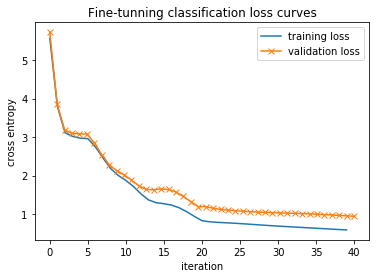

In [44]:
plt.title('Fine-tunning classification loss curves')
plt.plot(pretraining_training_loss, label='training loss')
plt.plot(np.linspace(0, len(pretraining_training_loss), len(pretraining_validation_loss)), pretraining_validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();

In [45]:
classification_test(classifier, encoder, test_dataloader, cross_entropy, epoch, []);

[20, test] loss: 0.875 accuracy: 72.540


The losses continue decreasing, although at a slower peace.

## Fine-tuning

In this section we will train attach a classifier to the encoder from the autoencoder and train both from the start, with a smaller learning rate for the encoder.

In [0]:
encoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).encoder.to(device)
encoder.load_state_dict(autoencoder_checkpoint["encoder"])
# Define classification layer.
classifier = torch.nn.Linear(bottleneck_size, 10).to(device)

In [0]:
optimizer_adam = torch.optim.Adam([
    {'params': classifier.parameters(), 'lr': 1e-2},
    {'params': encoder.parameters(), 'lr': 1e-5}
], lr=1e-3)

In [48]:
finetuning_training_loss = []
finetuning_validation_loss = []
min_loss = float('inf')

for epoch in range(EPOCHS_PRETRAINING + EPOCHS_FINETUNING):
    classifier.eval()
    encoder.eval()
    with torch.no_grad():
        loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, finetuning_validation_loss)
        if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_fine-tuning.pt')
    classifier.train()
    encoder.train()
    classification_train(classifier, encoder, subset_dataloader,
                         cross_entropy, optimizer_adam, epoch, finetuning_training_loss)

classifier.eval()
encoder.eval()
with torch.no_grad():
    loss, _ = classification_test(classifier, encoder, val_dataloader, cross_entropy, epoch, finetuning_validation_loss)
    if loss < min_loss:
            min_loss = loss
            torch.save({'classifier': classifier.state_dict(),
                        'encoder': encoder.state_dict()},
                       'best_fine-tuning.pt')

[1, test] loss: 6.546 accuracy: 8.100
[1, 0] loss: 7.378
[2, test] loss: 5.078 accuracy: 2.200
[2, 0] loss: 5.459
[3, test] loss: 4.151 accuracy: 2.933
[3, 0] loss: 4.364
[4, test] loss: 4.150 accuracy: 5.467
[4, 0] loss: 4.293
[5, test] loss: 4.407 accuracy: 7.400
[5, 0] loss: 4.527
[6, test] loss: 4.339 accuracy: 8.733
[6, 0] loss: 4.385
[7, test] loss: 3.961 accuracy: 9.800
[7, 0] loss: 3.897
[8, test] loss: 3.521 accuracy: 10.433
[8, 0] loss: 3.325
[9, test] loss: 3.283 accuracy: 9.600
[9, 0] loss: 2.988
[10, test] loss: 3.257 accuracy: 11.100
[10, 0] loss: 2.925
[11, test] loss: 3.181 accuracy: 14.667
[11, 0] loss: 2.835
[12, test] loss: 2.927 accuracy: 20.033
[12, 0] loss: 2.570
[13, test] loss: 2.582 accuracy: 26.200
[13, 0] loss: 2.217
[14, test] loss: 2.322 accuracy: 33.533
[14, 0] loss: 1.972
[15, test] loss: 2.179 accuracy: 39.900
[15, 0] loss: 1.858
[16, test] loss: 2.047 accuracy: 43.667
[16, 0] loss: 1.733
[17, test] loss: 1.887 accuracy: 47.533
[17, 0] loss: 1.567
[18, t

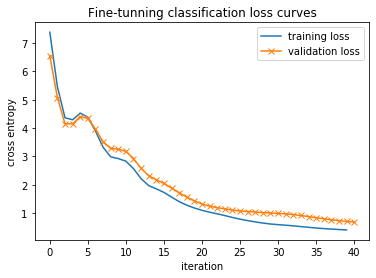

In [49]:
plt.title('Fine-tunning classification loss curves')
plt.plot(finetuning_training_loss, label='training loss')
plt.plot(np.linspace(0, len(finetuning_training_loss), len(finetuning_validation_loss)), finetuning_validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();

We obtain better accuracy than with the previous method. It looks like the loss is starting to settle.

## From scratch

In this section we will train a classifier with the same convolutional-encoder + fully-connected architecture as the previous model, but without pretraining the encoder part with and autoencoder.

In [0]:
new_autoencoder = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=50
).to(device)

new_classifier = torch.nn.Sequential(
    new_autoencoder.encoder,
    torch.nn.Linear(50, 10)
).to(device)

In [0]:
def new_classification_train(classifier, dataloader, criterion, classifier_optimizer, epoch, loss_history):
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        classifier_optimizer.zero_grad()
        # To latent space + Classify from latent space.
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()              # Backprop.
        classifier_optimizer.step()  # Update parameters.

        loss_history.append(loss.item())
        print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))

In [0]:
def new_classification_test(classifier, dataloader, criterion, epoch, loss_history):
    loss = 0
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device, torch.long)
        outputs = classifier(images)
        loss += criterion(outputs, labels).item()
        # Compute average accuracy.
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    mean_loss = loss / (i + 1)
    acc = 100 * correct / total
    loss_history.append(mean_loss)  
    print('[%d, validation] loss: %.3f accuracy: %.3f' % (epoch + 1, mean_loss, acc))
    return mean_loss, acc

In [0]:
cross_entropy = torch.nn.CrossEntropyLoss()
new_classifier_adam = torch.optim.Adam(new_classifier.parameters(), lr=0.001)

In [54]:
new_training_loss = []
new_validation_loss = []
min_loss = float('inf')

for epoch in range(EPOCHS_AUTOENCODER + EPOCHS_PRETRAINING + EPOCHS_FINETUNING):
    new_classifier.eval()
    with torch.no_grad():
        loss, _ = new_classification_test(new_classifier, val_dataloader, cross_entropy, epoch, new_validation_loss)
        if loss < min_loss:
            min_loss = loss
            torch.save(new_classifier.state_dict(), 'best_from-scratch.pt')
    new_classifier.train()
    new_classification_train(new_classifier, subset_dataloader,
                         cross_entropy, new_classifier_adam, epoch, new_training_loss)

new_classifier.eval()
with torch.no_grad():
    loss, _ = new_classification_test(new_classifier, val_dataloader, cross_entropy, epoch, new_validation_loss)
    if loss < min_loss:
        min_loss = loss
        torch.save(new_classifier.state_dict(), 'best_from-scratch.pt')

[1, validation] loss: 2.307 accuracy: 10.033
[1, 0] loss: 2.304
[2, validation] loss: 2.306 accuracy: 9.333
[2, 0] loss: 2.300
[3, validation] loss: 2.302 accuracy: 11.200
[3, 0] loss: 2.291
[4, validation] loss: 2.293 accuracy: 15.433
[4, 0] loss: 2.272
[5, validation] loss: 2.282 accuracy: 11.633
[5, 0] loss: 2.237
[6, validation] loss: 2.296 accuracy: 9.867
[6, 0] loss: 2.198
[7, validation] loss: 2.266 accuracy: 9.900
[7, 0] loss: 2.133
[8, validation] loss: 2.170 accuracy: 20.033
[8, 0] loss: 2.027
[9, validation] loss: 2.047 accuracy: 46.767
[9, 0] loss: 1.876
[10, validation] loss: 1.875 accuracy: 53.300
[10, 0] loss: 1.650
[11, validation] loss: 1.668 accuracy: 58.067
[11, 0] loss: 1.381
[12, validation] loss: 1.467 accuracy: 60.533
[12, 0] loss: 1.128
[13, validation] loss: 1.400 accuracy: 58.133
[13, 0] loss: 0.944
[14, validation] loss: 1.239 accuracy: 62.933
[14, 0] loss: 0.788
[15, validation] loss: 1.332 accuracy: 60.133
[15, 0] loss: 0.713
[16, validation] loss: 1.373 ac

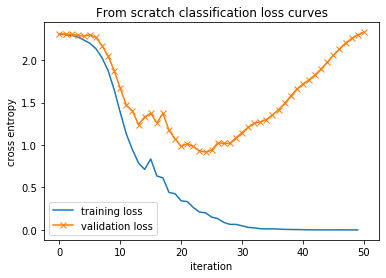

In [55]:
plt.title('From scratch classification loss curves')
plt.plot(new_training_loss, label='training loss')
plt.plot(np.linspace(0, len(new_training_loss), len(new_validation_loss)), new_validation_loss, '-x', label='validation loss')
plt.xlabel('iteration')
plt.ylabel('cross entropy')
plt.legend();

This learning curves show clear symptoms of overfitting. As the training set is so small, it perfectly fits it, but the validation error goes up.

In [56]:
new_classification_test(new_classifier, test_dataloader, cross_entropy, epoch, []);

[50, validation] loss: 2.306 accuracy: 79.040


## Comparison

Load best models (early-stopping).

In [0]:
autoencoder_pretrain = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).to(device)
classifier_pretrain = torch.nn.Linear(bottleneck_size, 10).to(device)

pretrain_checkpoint = torch.load('best_pretrain.pt')
autoencoder_pretrain.encoder.load_state_dict(pretrain_checkpoint['encoder'])
classifier_pretrain.load_state_dict(pretrain_checkpoint['classifier'])

autoencoder_finetuning = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).to(device)
classifier_finetuning = torch.nn.Linear(bottleneck_size, 10).to(device)

finetuning_checkpoint = torch.load('best_fine-tuning.pt')
autoencoder_finetuning.encoder.load_state_dict(finetuning_checkpoint['encoder'])
classifier_finetuning.load_state_dict(finetuning_checkpoint['classifier'])

autoencoder_pretrain_finetuning = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).to(device)
classifier_pretrain_finetuning= torch.nn.Linear(bottleneck_size, 10).to(device)

pretrain_finetuning_checkpoint = torch.load('best_pretraining+fine-tuning.pt')
autoencoder_pretrain_finetuning.encoder.load_state_dict(pretrain_finetuning_checkpoint['encoder'])
classifier_pretrain_finetuning.load_state_dict(pretrain_finetuning_checkpoint['classifier'])

autoencoder_fromscratch = ConvolutionalAutoencoderReducedLatentDim(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=bottleneck_size
).to(device)

classifier_fromscratch = torch.nn.Sequential(
    autoencoder_fromscratch.encoder,
    torch.nn.Linear(bottleneck_size, 10)
).to(device)

classifier_fromscratch.load_state_dict(torch.load('best_from-scratch.pt'));

Compare cross entropy loss and accuracy on validation and test sets.

In [58]:
tbl = PrettyTable()
tbl.field_names = ["model","validation loss", "validation acc.", "test loss", "test acc."]
pair_models = {"pretrained": (classifier_pretrain, autoencoder_pretrain.encoder), 
               "pretrain+finetuning": (classifier_pretrain_finetuning, autoencoder_pretrain_finetuning.encoder),
               "finetuned": (classifier_finetuning, autoencoder_finetuning.encoder)
              }
losses = {"pretrained": None, "pretrain+finetuning": None, "finetuned": None, "scratch": None}
for name, models in pair_models.items():
    print(name + " train:")
    val_loss, val_acc = classification_test(models[0], models[1], val_dataloader, cross_entropy, epoch, [])
    print(name + " test:")
    test_loss, test_acc = classification_test(models[0], models[1], test_dataloader, cross_entropy, epoch, [])
    losses[name] = test_loss
    tbl.add_row([name,val_loss,val_acc,test_loss,test_acc])

print("scratch train")
val_loss, val_acc = new_classification_test(classifier_fromscratch, val_dataloader, cross_entropy, epoch, [])
print("scratch test")
test_loss, test_acc = new_classification_test(classifier_fromscratch, test_dataloader, cross_entropy, epoch, [])
losses["scratch"] = test_loss
tbl.add_row(
    ["scratch", val_loss, val_acc, test_loss, test_acc])
print(tbl)



pretrained train:
[50, test] loss: 1.195 accuracy: 61.933
pretrained test:
[50, test] loss: 1.126 accuracy: 63.740
pretrain+finetuning train:
[50, test] loss: 0.944 accuracy: 70.433
pretrain+finetuning test:
[50, test] loss: 0.875 accuracy: 72.540
finetuned train:
[50, test] loss: 0.689 accuracy: 79.967
finetuned test:
[50, test] loss: 0.642 accuracy: 80.680
scratch train
[50, validation] loss: 0.918 accuracy: 75.767
scratch test
[50, validation] loss: 0.896 accuracy: 77.440
+---------------------+--------------------+-------------------+--------------------+-----------+
|        model        |  validation loss   |  validation acc.  |     test loss      | test acc. |
+---------------------+--------------------+-------------------+--------------------+-----------+
|      pretrained     | 1.195295164982478  | 61.93333333333333 |  1.12577568277528  |   63.74   |
| pretrain+finetuning | 0.9442889740069708 | 70.43333333333334 | 0.8747085166882865 |   72.54   |
|      finetuned      | 0.6893

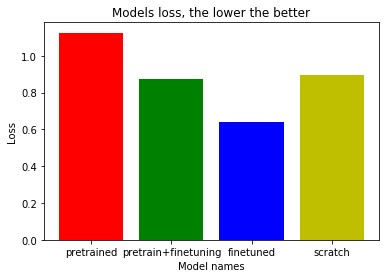

In [59]:
models_names = tuple(losses.keys())
loss = tuple(losses.values())
y_pos = np.arange(len(loss))

plt.bar(y_pos, loss, color=("r", "g", "b", "y"))
plt.xticks(y_pos, models_names)
plt.xlabel("Model names")
plt.ylabel("Loss")
plt.title("Models loss, the lower the better")
plt.show();

As we can see, the best model is the "finetune" one. The autoencoder training process help the encoder learn general representations that then are finetuned along with the classifier network; this proceidure works best than first training the classifier without updating the encoder and then finetuning and also than training the whole network from scratch as this one quickly overfits.

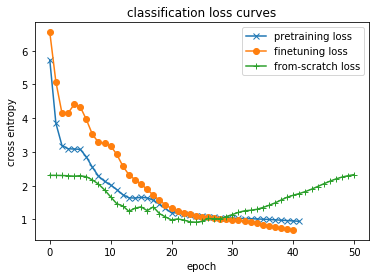

In [60]:
plt.title('classification loss curves')
plt.plot(pretraining_validation_loss, '-x', label='pretraining loss')
plt.plot(finetuning_validation_loss, '-o', label='finetuning loss')
plt.plot(new_validation_loss, '-+', label='from-scratch loss')
plt.xlabel('epoch')
plt.ylabel('cross entropy')
plt.legend();

The pratraining and finetuning loss curves look very similar, as they are in fact similar processes. The from-scratch loss curves follows the aforementioned "overfitting shape".

## Optional Exercise A: Variational Autoencoder

Steps:

1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.
2. Train the model optimizing the Evidence Lower Bound (ELBO).
3. Generate samples with the decoder and show them.


New class for variational autoencoder based on the previous autoencoder.

In the bottleneck instead of one fully-connected layer, we define two: one will predict the mean and the otherone the variance (actually the log of the variance for performance matters). Instead of feeding the output of the encoder to the decooder, the distribution defined by the encoder is sampled via the reparametrization trick.

In this case we use a sigmoid activation function for the last decoder layer as the reconstruction loss "demands it".

In [0]:
class ConvolutionalVAE(torch.nn.Module):

    def __init__(self, input_shape, n_blocks, downsampling_method, upsampling_method,
                 layers_per_block=2, latent_dimensionality=50):
        super().__init__()
        self.n_blocks = n_blocks
        self.downsampling_method = downsampling_method
        self.upsampling_method = upsampling_method
        self.latent_dimensionality = latent_dimensionality

        # Encoder: Convolutional blocks + Linear
        self.convolutional_encoder = ConvolutionalEncoder(
            n_blocks, downsampling_method, layers_per_block=layers_per_block)
        self.encoder_output_shape = (self.convolutional_encoder.init_filters * 2 ** (n_blocks - 1),
                                     input_shape[0] // 2 ** n_blocks,
                                     input_shape[1] // 2 ** n_blocks)
        self.mu = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2],
                            latent_dimensionality),
        )
        self.log_var = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2],
                            latent_dimensionality),
        )

        # Decoder: Linear + Convolutional blocks
        self.linear_decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dimensionality,
                            self.encoder_output_shape[0] * self.encoder_output_shape[1] * self.encoder_output_shape[2]),
            torch.nn.ReLU()
        )
        self.convolutional_decoder = ConvolutionalDecoder(
            n_blocks, upsampling_method,
            self.convolutional_encoder.output_channels, layers_per_block,
            activation="sigmoid")

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        return torch.randn_like(std).mul(std).add_(mu)

    def forward(self, x):
        encoder_output = self.convolutional_encoder(x)
        # Get mean and variance.
        mu = self.mu(encoder_output)
        log_var = self.log_var(encoder_output)
        # Sample from a normal distribution of mean mu and variance var.
        code = self.reparameterize(mu, log_var)

        reconstruction = self.convolutional_decoder(
            self.linear_decoder(code).view((-1,) + self.encoder_output_shape))
        
        # Return reconstruction and mean and variance for the loss computation.  
        return reconstruction, mu, log_var

Reconstruction + KL divergence losses summed over all elements and batch


In [0]:
from torch.nn.functional import binary_cross_entropy

In [0]:
def loss_function(recon_x, x, mu, logvar):
    BCE = binary_cross_entropy(recon_x.view(-1, 28 * 28), x.view(-1, 28 * 28), reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [0]:
def train(vae, dataloader, optimizer, epoch, loss_history, log_interval=100):
    for i, batch in enumerate(dataloader):
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed, mu, log_var = vae(images)
        # Divide by batch size to compute mean image reconstruction error.
        loss = loss_function(reconstructed, images, mu, log_var)
        loss.backward()   # Backprop.
        optimizer.step()  # Parameter updates.

        loss_history.append(loss.item())
        if i % log_interval == 0:
            print('[%d, %d] loss: %.3f' % (epoch + 1, i, loss.item()))


In [0]:
vae = ConvolutionalVAE(
    input_shape=(28, 28),
    n_blocks=2,
    downsampling_method='max-pooling',
    upsampling_method='nearest',
    layers_per_block=2,
    latent_dimensionality=50
).to(device)

adam = torch.optim.Adam(vae.parameters(), lr=0.0001)

In this case we don't normalize the data because we use a sigmoid as the last activation function.

In [0]:
mnist = torchvision.datasets.MNIST('mnist_dataset', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_dataloader = torch.utils.data.DataLoader(mnist,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=4)

In [70]:
training_loss = []    #
validation_loss = []  # Here we save the training process.

vae.train()
for epoch in range(EPOCHS_VAE):
    train(vae, train_dataloader, adam, epoch, training_loss)

vae.eval();

[1, 0] loss: 68370.188
[1, 100] loss: 29575.402
[1, 200] loss: 27427.656
[1, 300] loss: 25421.096
[1, 400] loss: 25411.174
[2, 0] loss: 23681.994
[2, 100] loss: 24482.270
[2, 200] loss: 23669.783
[2, 300] loss: 21638.762
[2, 400] loss: 22024.057
[3, 0] loss: 20623.914
[3, 100] loss: 20091.514
[3, 200] loss: 19591.807
[3, 300] loss: 19427.857
[3, 400] loss: 18717.400
[4, 0] loss: 17924.871
[4, 100] loss: 18158.688
[4, 200] loss: 16909.822
[4, 300] loss: 17566.412
[4, 400] loss: 17491.938
[5, 0] loss: 16820.479
[5, 100] loss: 16534.318
[5, 200] loss: 16648.293
[5, 300] loss: 16986.096
[5, 400] loss: 15790.154
[6, 0] loss: 16247.808
[6, 100] loss: 16501.914
[6, 200] loss: 16000.347
[6, 300] loss: 16319.369
[6, 400] loss: 15830.389
[7, 0] loss: 15580.254
[7, 100] loss: 16399.617
[7, 200] loss: 15593.954
[7, 300] loss: 15507.785
[7, 400] loss: 15654.609
[8, 0] loss: 15333.086
[8, 100] loss: 14815.798
[8, 200] loss: 15866.573
[8, 300] loss: 15483.954
[8, 400] loss: 15269.951
[9, 0] loss: 156

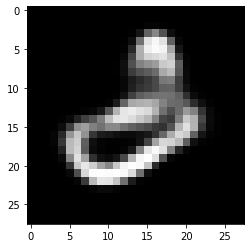

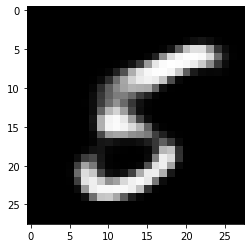

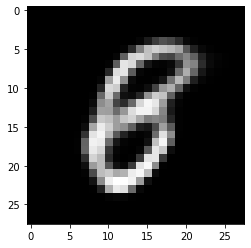

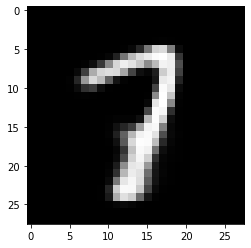

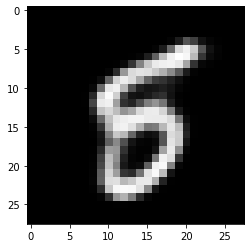

In [74]:
for _ in range(5):
    plt.figure()
    generate_image(vae)


The generated images by the variational autoencoder look similar to the training data, at least a lot more similar than the "deterministic" autoencoder.